# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [33]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder

In [63]:
df = pd.read_csv('Traffic Data.csv' , parse_dates=['date_time'] , index_col='date_time', dayfirst=True)
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [38]:
df.duplicated().sum()

18

In [39]:
df.drop_duplicates(inplace=True)

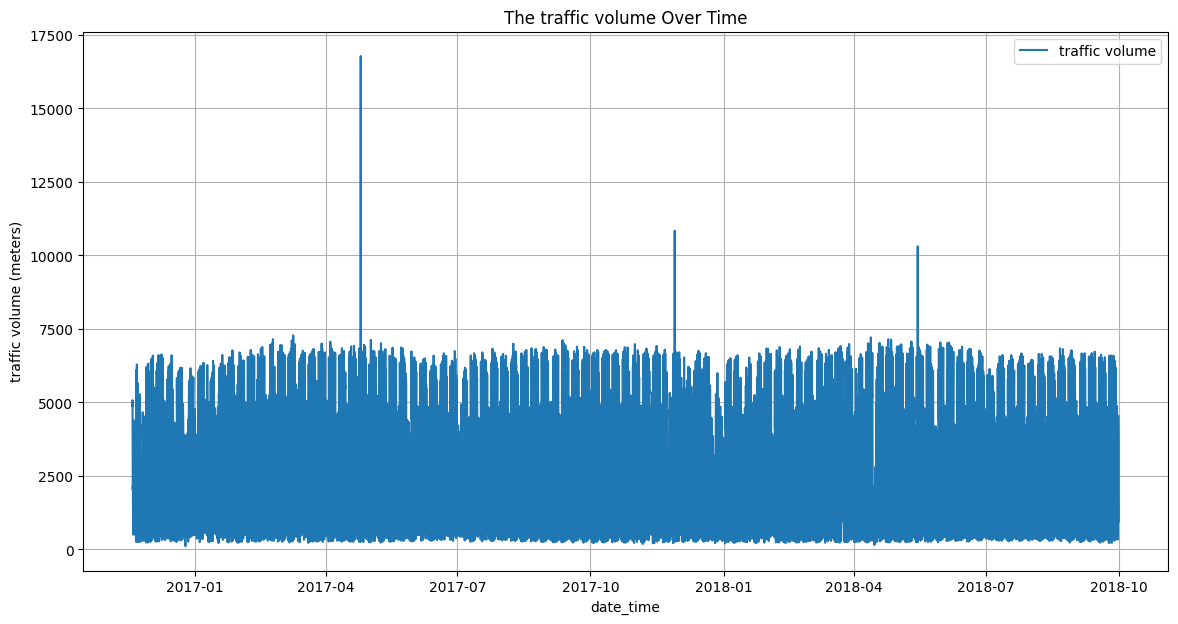

In [40]:
# Plot the time series data for Depth_to_Groundwater_P24
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['traffic_volume'], label='traffic volume')
plt.title('The traffic volume Over Time')
plt.xlabel('date_time')
plt.ylabel('traffic volume (meters)')
plt.legend()
plt.grid(True)
plt.show()

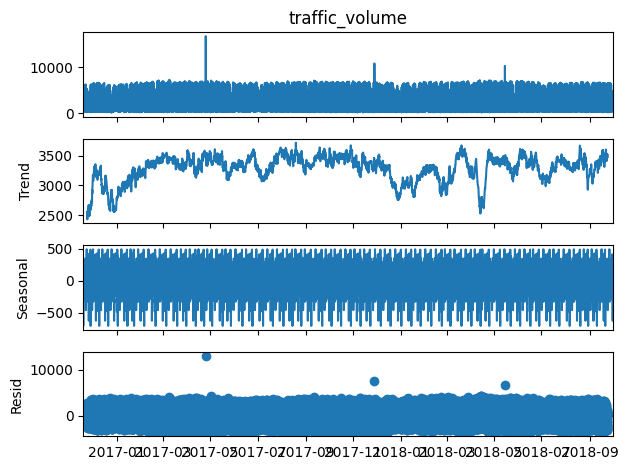

In [49]:
deccomposition = seasonal_decompose(df['traffic_volume'].dropna(), model='additive', period=365)
deccomposition.plot()
plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [41]:
df.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [42]:
df.isna().mean()*100

,0
traffic_volume,0.10009
temp,0.00000
rain_1h,0.00000
snow_1h,0.00000
clouds_all,0.00000
weather_main,0.00000
weather_description,0.00000


In [47]:
# Here is about fill missing values in numeric columns only we have just the traffic volume has missing
for col in df.select_dtypes(include=['number']):
    df[col].fillna(df[col].mean(), inplace=True)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [65]:
# Here is about create moving average features for traffic_volume
df['traffic_volume_MA7'] = df['traffic_volume'].rolling(window=7).mean()  # 7-hour moving average
df['traffic_volume_MA24'] = df['traffic_volume'].rolling(window=24).mean()  # 24-hour moving average
df['traffic_volume_MA168'] = df['traffic_volume'].rolling(window=168).mean()  # 168-hour (1 week) moving average


In [66]:
# Create time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [67]:
df.dropna()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume_MA7,traffic_volume_MA24,traffic_volume_MA168,hour,day_of_week,month,is_weekend
date_time,,,,,,,,,,,,,,
2018-09-19 22:00:00,1693.0,287.91,0.0,0.0,90,Drizzle,light intensity drizzle,2628.000000,2521.333333,3261.357143,22,2,9,0
2017-12-15 06:00:00,5506.0,268.15,0.0,0.0,90,Clouds,overcast clouds,2890.285714,2693.833333,3286.934524,6,4,12,0
2017-10-27 16:00:00,6061.0,274.15,0.0,0.0,90,Fog,fog,3620.285714,2928.916667,3315.583333,16,4,10,0
2017-12-06 18:00:00,4144.0,265.08,0.0,0.0,90,Haze,haze,3700.285714,3090.291667,3312.857143,18,2,12,0
2016-11-22 09:00:00,4607.0,273.81,0.0,0.0,90,Rain,light rain,3910.428571,3081.666667,3323.386905,9,1,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-06 21:00:00,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,3347.000000,3356.583333,3287.535714,21,2,6,0
2017-10-25 15:00:00,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,3623.285714,3472.333333,3320.767857,15,2,10,0
2018-03-28 23:00:00,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,3356.285714,3328.750000,3312.297619,23,2,3,0


In [59]:
# Here is about ensure the index is sorted
df.sort_index(inplace=True)

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [70]:
# Here is about calculate the difference between consecutive traffic_volume values
df['traffic_volume_diff'] = df['traffic_volume'].diff()

In [71]:
# Here is about create a new column for the previous days traffic volume
df['prev_traffic_volume'] = df['traffic_volume'].shift(24)

In [72]:
df = df.dropna()
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume_MA7,traffic_volume_MA24,traffic_volume_MA168,hour,day_of_week,month,is_weekend,traffic_volume_diff,prev_traffic_volume
date_time,,,,,,,,,,,,,,,,
2018-09-19 22:00:00,1693.0,287.91,0.0,0.0,90,Drizzle,light intensity drizzle,2628.000000,2521.333333,3261.357143,22,2,9,0,1044.0,1383.0
2017-12-15 06:00:00,5506.0,268.15,0.0,0.0,90,Clouds,overcast clouds,2890.285714,2693.833333,3286.934524,6,4,12,0,3813.0,1366.0
2017-10-27 16:00:00,6061.0,274.15,0.0,0.0,90,Fog,fog,3620.285714,2928.916667,3315.583333,16,4,10,0,555.0,419.0
2017-12-06 18:00:00,4144.0,265.08,0.0,0.0,90,Haze,haze,3700.285714,3090.291667,3312.857143,18,2,12,0,-1917.0,271.0
2016-11-22 09:00:00,4607.0,273.81,0.0,0.0,90,Rain,light rain,3910.428571,3081.666667,3323.386905,9,1,11,0,463.0,4814.0


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [158]:
X = df.drop(columns=['traffic_volume'])
y = df['traffic_volume']

In [159]:
# Here is about a split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [160]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=[object]).columns.tolist()

In [161]:
# Here is about loop for apply label encoding to categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

In [162]:
# Here is about scaling the dataset with MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[numerical_features])
test_scaled = scaler.transform(test[numerical_features])

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [163]:
# Model of the LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32, activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

# Here is a compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 1, 64)               │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,929 (128.63 KB)

 Trainable params: 32,929 (128.63 KB)

 Non-trainable params: 0 (0.00 B)

In [164]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [165]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0150 - val_loss: 0.0031
Epoch 2/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 3/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 4/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 5/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 6/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 7/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 8/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 9/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 10/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 11/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 12/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [166]:
y_pred = lstm_model.predict(X_test)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [167]:
# Here is about calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

MAE: 0.020180687018940956


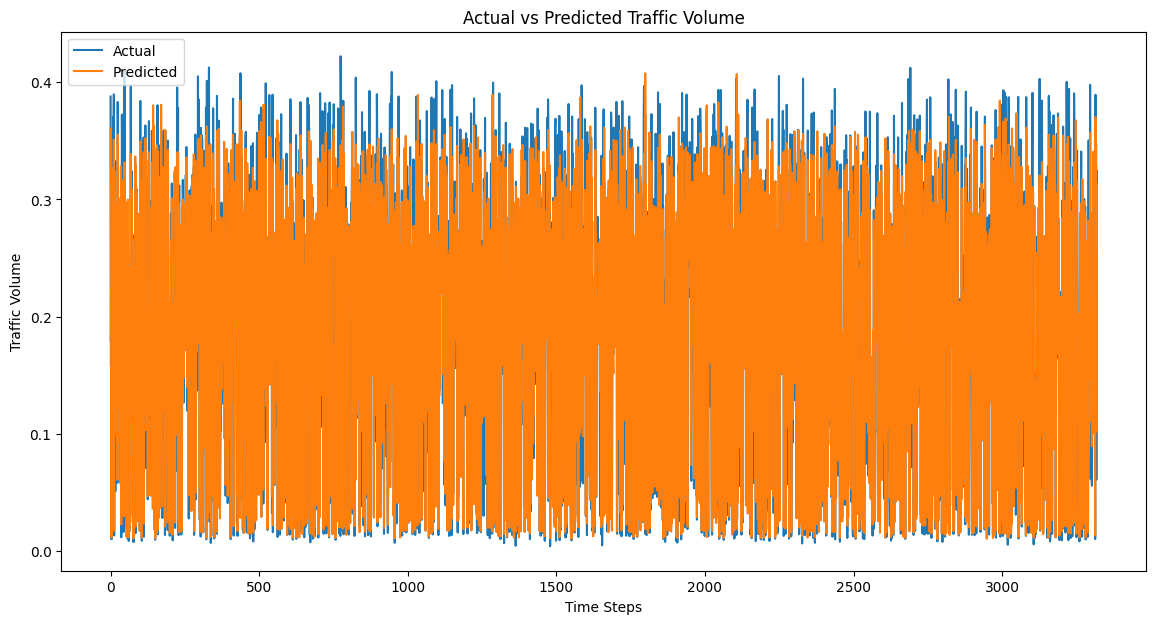

In [168]:
# Here plot of predicted
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

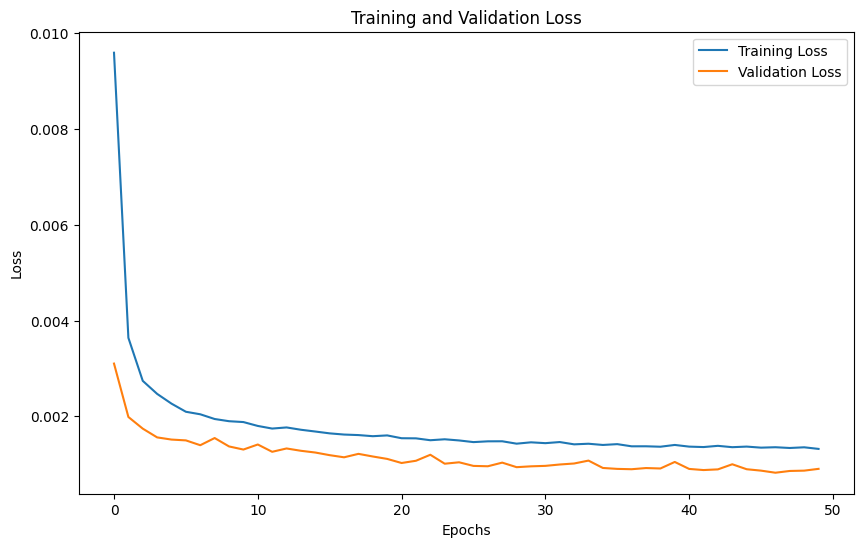

In [169]:
# Here is about plot of loss
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [170]:
#Model of GRU
gru_model = Sequential()
gru_model.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(32, activation='relu', return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1))

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

gru_model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 1, 64)               │          15,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,993 (97.63 KB)

 Trainable params: 24,993 (97.63 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [172]:
gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0167 - val_loss: 0.0036
Epoch 2/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 3/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 4/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 5/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 6/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 7/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 8/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 9/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 10/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 11/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 12/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [173]:
y_pred = gru_model.predict(X_test)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [174]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

MAE: 0.020110485633959906


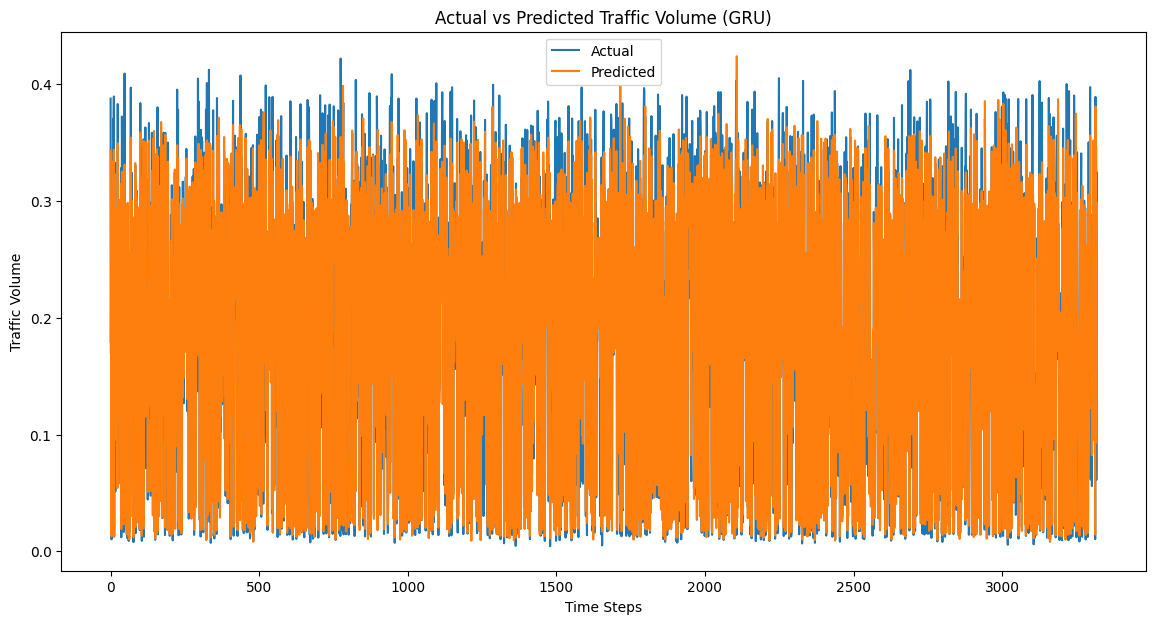

In [175]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Traffic Volume (GRU)')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

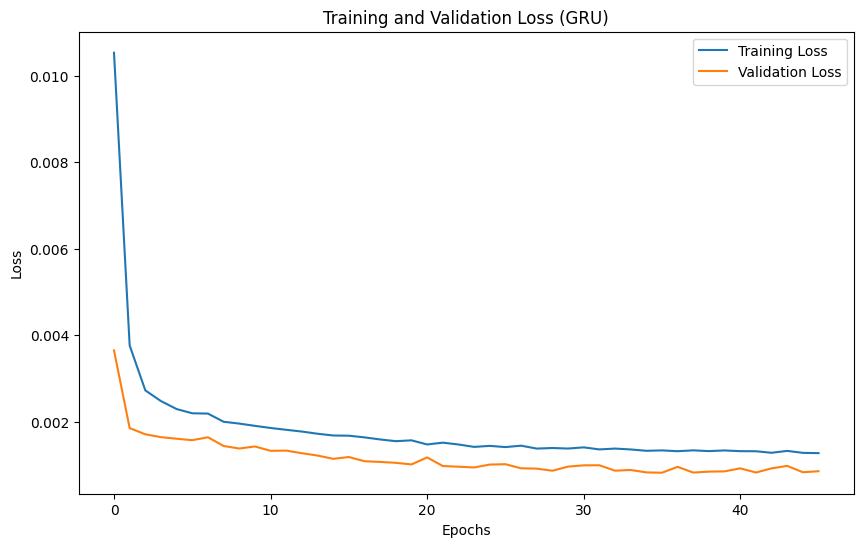

In [176]:
plt.figure(figsize=(10, 6))
plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

1- Data Preprocessing: I use the MinMaxScaler for normalize the data and also scaling for feature it will make the range between 0 and 1, both of this technique is useful for model, also I used filling the missing values because the missing values it was in the target columns, also I used drop duplicated.

2- Feature Engineering: I used label encoding because it was 2 feature object
and also creating a new column for previous days and also anthor for difference between them, and the goal from them to make the patterns data more accessible to the model.

3- Model Architecture: I chooes two model LSTM and GRU models.

4- Training Process : Batch sizes I write 32 and it can help smooth the model, I chooes wit input layers and hidden layers and the output layers the dropout because the model it was overfitting.

5- Loss Function and Metrics : I used Mean Squared Error for both models because it penalizes larger errors more than smaller ones, for the LSTM it show
02 score and the GRU it show mostly same.

6- Model Tuning : after traing the model the loss is going down for both of them and the predicted mostly can read the trend.

7- Overfitting and Underfitting : I used the early stopping.